Применим градиентный бустинг

# Импорт библиотек и данных

Launch a server via:
```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor

import optuna
from optuna.trial import Trial

root_folder = '../'
sys.path.append(root_folder)

from src.models import train_model, predict_model
from src.visualization import visualize
from src.utils import get_dict

train_path = Path(root_folder, 'data', 'processed', '2.0_train.csv')
test_path = Path(root_folder, 'data', 'processed', '2.0_test.csv')

experiment_name = 'Housing cost'

random_state = 42

Загрузим датасеты:

In [2]:
train = pd.read_csv(train_path, index_col=0)
train.info()
X_train, y_train = train_model.get_X_y(train, target_name='log_target')
print()
print()

test = pd.read_csv(test_path, index_col=0)
test.info()
X_test, y_test = train_model.get_X_y(test, target_name='log_target')

<class 'pandas.core.frame.DataFrame'>
Index: 264639 entries, 0 to 264638
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            264639 non-null  float64
 1   fireplace                        264639 non-null  bool   
 2   beds                             264639 non-null  float64
 3   stories                          264639 non-null  float64
 4   private_pool                     264639 non-null  bool   
 5   parking_count                    264639 non-null  float64
 6   central_heating                  264639 non-null  bool   
 7   central_cooling                  264639 non-null  bool   
 8   log_target                       264639 non-null  float64
 9   log_sqft                         264639 non-null  float64
 10  log_lotsize                      264639 non-null  float64
 11  updated_years                    264639 non-null  float64
 12  school_

## Pure GradientBoostingRegressor

GradientBoostingRegressor, как и другие модели на деревьях решений не требует масштабирования признаков. Также не будем создавать полиномиальные признаки.

Сначала идёт `SimpleImputer` на случай, если при использовании этой модели попадутся NaN-ы.
Сейчас пропусков нет.

В конце - модель GradientBoostingRegressor.

In [3]:
# selector_params = get_dict(
#     score_func=f_regression,
#     k=15,
# )

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

gb_params = get_dict(
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    random_state=random_state,
)

pipe_elements = [
    # ('selector', SelectKBest, selector_params),
    ('imputer', SimpleImputer, imputer_params),
    ('regressor', GradientBoostingRegressor, gb_params)
]

pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
cv_metrics = predict_model.cross_validate_pipe(
    pipe=pipe,
    X=X_train,
    y=y_train,
    njobs=3
)

pipe.fit(X_train, y_train)
metrics = predict_model.get_train_test_metrics(
    pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
metrics = metrics | cv_metrics

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 RandomForestRegressor(max_depth=12, n_estimators=10,
                                       random_state=42))])

,cv_train,cv_validation
mape_log,0.030,0.032
r2_log,0.650,0.610


,train,test
mape,0.425,0.454
r2,0.603,0.535


In [4]:
model_info = predict_model.log_pipe_mlflow(
    pipe_name='gradient-boosting-all',
    training_info='Gradient Boosting with all features',
    X=X_train,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
    experiment_name=experiment_name,
)

Registered model 'random-forest-all' already exists. Creating a new version of this model...
2024/04/25 11:52:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-all, version 2
Created version '2' of model 'random-forest-all'.


Удалось получить наименьший процент ошибки `MAPE`, чем в бейзлайнах и регуляризации: $45.4$% против 47.5% на Ridge.

$R^2 = 0.535$ лучше чем у дерева решений (0.492)

## Лучшие признаки

Оценим важность признаков:

,feature,importance
8,log_sqft,0.350771
0,baths,0.151368
17,state_CA,0.071672
27,property_type_land/mobile,0.071555
10,updated_years,0.053580
20,state_NY,0.048581
14,median_school_rating,0.038670
26,property_type_condo,0.025301
21,state_OH,0.021958
24,state_WA,0.020128


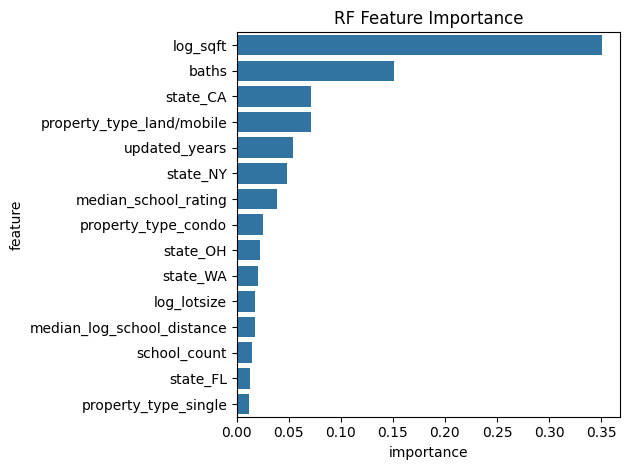

In [4]:
feature_importances = pd.DataFrame(
    {
        'feature': pipe[-2].get_feature_names_out(),
        'importance': pipe[-1].feature_importances_, 
    }
).sort_values(by='importance', ascending=False)

selected_feature_importances = feature_importances.iloc[:15]

display(selected_feature_importances)
visualize.plot_bar(
    selected_feature_importances,
    numeric_feature='importance',
    categorical_feature='feature',
    title='RF Feature Importance',
);

Также посмотрим на лучшие признаки методом f_regression

Пока не отсекаем признаки

In [5]:
selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)

features_kbest = selector.get_feature_names_out()
display(features_kbest)

# X_train = X_train[features_kbest]
# X_train.info()

array(['baths', 'fireplace', 'beds', 'stories', 'private_pool',
       'parking_count', 'log_sqft', 'updated_years',
       'median_school_rating', 'status_foreclosure/pending', 'state_CA',
       'state_NY', 'state_OH', 'property_type_land/mobile',
       'parking_type_garage'], dtype=object)

Общие признаки методом `SelectKBest` и `RF Feature Importance`

In [6]:
common_features = set(features_kbest).intersection(
        set(selected_feature_importances['feature'])
    )
print(f'Общие признаки ({len(common_features)}):')
# common_features = list(common_features)

display(
    common_features
)

excluded_from_RF = set(features_kbest)\
    - set(selected_feature_importances['feature'])
print('Невошедшие в "RF feature importances"')
display(excluded_from_RF)

excluded_from_kbest = set(selected_feature_importances['feature'])\
    - set(features_kbest)
print('Невошедшие в "features_kbest"')
display(excluded_from_kbest)

union_features = set(features_kbest).union(
    set(selected_feature_importances['feature'])
)
union_features = list(union_features)

print(f'Отобранные признаки ({len(union_features)}):')
# common_features = list(common_features)

display(
    union_features
)

X_train_best = X_train[union_features]
print(f'X_train_best: {X_train_best.shape}')

X_test_best = X_test[union_features]
print(f'X_test_best: {X_test_best.shape}')

Общие признаки (8):


{'baths',
 'log_sqft',
 'median_school_rating',
 'property_type_land/mobile',
 'state_CA',
 'state_NY',
 'state_OH',
 'updated_years'}

Невошедшие в "RF feature importances"


{'beds',
 'fireplace',
 'parking_count',
 'parking_type_garage',
 'private_pool',
 'status_foreclosure/pending',
 'stories'}

Невошедшие в "features_kbest"


{'log_lotsize',
 'median_log_school_distance',
 'property_type_condo',
 'property_type_single',
 'school_count',
 'state_FL',
 'state_WA'}

Отобранные признаки (22):


['status_foreclosure/pending',
 'log_sqft',
 'property_type_single',
 'median_school_rating',
 'parking_count',
 'state_OH',
 'fireplace',
 'state_NY',
 'school_count',
 'log_lotsize',
 'state_FL',
 'baths',
 'state_WA',
 'property_type_land/mobile',
 'updated_years',
 'private_pool',
 'state_CA',
 'parking_type_garage',
 'stories',
 'beds',
 'median_log_school_distance',
 'property_type_condo']

X_train_best: (264639, 22)
X_test_best: (66160, 22)


## Оптимизиция RandomForest

In [7]:
%%time

imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)

def optuna_rf(trial:Trial):
    rf_params = get_dict(
        n_estimators=trial.suggest_int('n_estimators', 50, 300, step=10),
        max_depth=trial.suggest_int('max_depth', 10, 30, step=2),
        min_samples_leaf = trial.suggest_int(
            'min_samples_leaf', 5, 40, step=5
        ),
        random_state = random_state
    )
    
    pipe_elements = [
        # ('selector', SelectKBest, selector_params),
        ('imputer', SimpleImputer, imputer_params),
        ('regressor', RandomForestRegressor, rf_params)
    ]
    
    pipe, pipe_params = train_model.make_pipeline(pipe_elements)
    
    # Conduct fitting and cross-validation metrics estimation
    cv_metrics = predict_model.cross_validate_pipe(
        pipe=pipe,
        X=X_train_best,
        y=y_train,
        cv=3,
        scoring=(
            'neg_mean_absolute_percentage_error',
            'r2',
        ),
        njobs=3
    )
    
    return cv_metrics['cv_validation_r2_log']

# init study with maximization
study = optuna.create_study(
    study_name='RandomForestRegressor',
    direction='maximize'
)
# get best combination of hyperparams n_trials times
study.optimize(optuna_rf, n_trials=20)

[I 2024-04-25 12:03:15,348] A new study created in memory with name: RandomForestRegressor


,cv_train,cv_validation
mape_log,0.028,0.030
r2_log,0.674,0.634


[I 2024-04-25 12:04:07,631] Trial 0 finished with value: 0.6342107056657218 and parameters: {'n_estimators': 70, 'max_depth': 26, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.6342107056657218.


,cv_train,cv_validation
mape_log,0.027,0.030
r2_log,0.697,0.644


[I 2024-04-25 12:07:33,338] Trial 1 finished with value: 0.6439380544870171 and parameters: {'n_estimators': 280, 'max_depth': 26, 'min_samples_leaf': 25}. Best is trial 1 with value: 0.6439380544870171.


,cv_train,cv_validation
mape_log,0.029,0.030
r2_log,0.663,0.630


[I 2024-04-25 12:09:12,858] Trial 2 finished with value: 0.6300535789009527 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.6439380544870171.


,cv_train,cv_validation
mape_log,0.030,0.031
r2_log,0.653,0.620


[I 2024-04-25 12:10:39,635] Trial 3 finished with value: 0.6199510741208127 and parameters: {'n_estimators': 140, 'max_depth': 14, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.6439380544870171.


,cv_train,cv_validation
mape_log,0.029,0.031
r2_log,0.671,0.625


[I 2024-04-25 12:11:24,254] Trial 4 finished with value: 0.6250147290882895 and parameters: {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.6439380544870171.


,cv_train,cv_validation
mape_log,0.029,0.030
r2_log,0.667,0.632


[I 2024-04-25 12:14:15,841] Trial 5 finished with value: 0.6316520868637413 and parameters: {'n_estimators': 240, 'max_depth': 30, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.6439380544870171.


,cv_train,cv_validation
mape_log,0.023,0.029
r2_log,0.771,0.664


[I 2024-04-25 12:17:43,309] Trial 6 finished with value: 0.6635171735310671 and parameters: {'n_estimators': 240, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 6 with value: 0.6635171735310671.
